In [1]:
import itk
import scipy
import skimage
import imageio
import matplotlib.pyplot as plt
import numpy as np
# %pylab inline

In [2]:
template = skimage.color.rgb2grey(imageio.imread('/Users/farid/Documents/Workspace/python/bactrace/data/samples/4_Pos_low Inflammation.tiff'))
sample = skimage.color.rgb2grey(imageio.imread('/Users/farid/Documents/Workspace/python/bactrace/data/samples/3_Pos_Inflammation.tiff'))

module 'imageio.plugins._tifffile' has no attribute 'decode_packbits'
  Functionality might be degraded or be slow.

module 'imageio.plugins._tifffile' has no attribute 'decode_lzw'
  Functionality might be degraded or be slow.

module 'imageio.plugins._tifffile' has no attribute 'unpack_ints'
  Functionality might be degraded or be slow.

module 'imageio.plugins._tifffile' has no attribute 'reverse_bitorder'
  Functionality might be degraded or be slow.



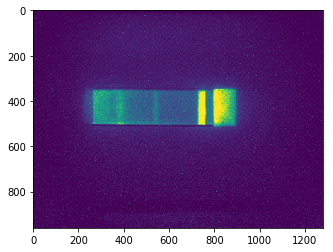

In [3]:
plt.imshow(template)

0 179


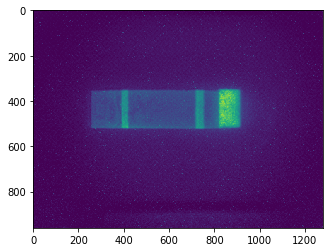

In [4]:
print(np.min(sample), np.max(sample))
plt.imshow(sample)

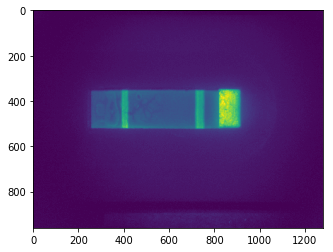

In [5]:
from scipy import ndimage
sample_med = ndimage.median_filter(sample, 5)
plt.imshow(sample_med)

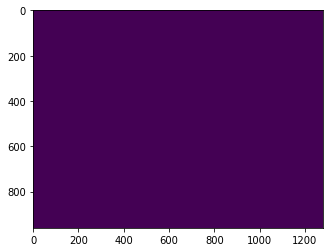

In [6]:
from skimage import feature
sample_edges = feature.canny(sample_med, sigma=0.1)
plt.imshow(sample_edges)

In [7]:
from scipy import ndimage
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

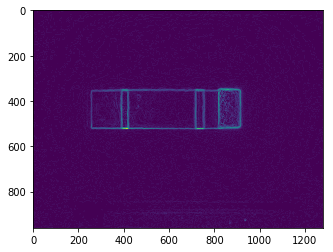

In [8]:
sample_blur = ndimage.gaussian_filter(sample_med, sigma=1)

(sample_sobel, theta) = sobel_filters(sample_blur.astype(np.float32))
plt.imshow(sample_sobel)

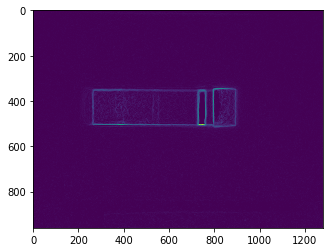

In [9]:
template_med = ndimage.median_filter(template, size=5)
template_blur = ndimage.gaussian_filter(template_med, sigma=1)

(template_sobel, theta) = sobel_filters(template_blur.astype(np.float32))
plt.imshow(template_sobel)

In [10]:
import SimpleITK as sitk

def command_iteration(method) :
    print("{0:3} = {1:7.5f} : {2}".format(method.GetOptimizerIteration(),
                                           method.GetMetricValue(),
                                           method.GetOptimizerPosition()))

In [11]:
fixed = sitk.GetImageFromArray(template)
fixed = sitk.Normalize(fixed)
fixed = sitk.DiscreteGaussian(fixed, 2.0)

In [12]:
moving = sitk.GetImageFromArray(sample)
moving = sitk.Normalize(moving)
moving = sitk.DiscreteGaussian(moving, 2.0)

In [13]:
R = sitk.ImageRegistrationMethod()

R.SetMetricAsJointHistogramMutualInformation()
# R.SetMetricAsCorrelation()

R.SetOptimizerAsGradientDescentLineSearch(learningRate=1.0,
                                          numberOfIterations=200,
                                          convergenceMinimumValue=1e-5,
                                          convergenceWindowSize=5)

In [14]:
R.SetInitialTransform(sitk.Euler2DTransform()) #fixed.GetDimension()

R.SetInterpolator(sitk.sitkLinear)

R.AddCommand( sitk.sitkIterationEvent, lambda: command_iteration(R) )

outTx = R.Execute(fixed, moving)

print("-------")
print(outTx)
print("Optimizer stop condition: {0}".format(R.GetOptimizerStopConditionDescription()))
print(" Iteration: {0}".format(R.GetOptimizerIteration()))
print(" Metric value: {0}".format(R.GetMetricValue()))

  0 = -0.31803 : (0.008910998500011307, 3.988702973671029e-05, 5.669334640177541e-05)
  1 = -0.32162 : (0.007912688895162168, 4.209466828697473e-05, 5.7211059529153584e-05)
  2 = -0.32149 : (0.007703634653176794, 4.260622865996912e-05, 5.7371887926231866e-05)
  3 = -0.32150 : (0.007596188639428829, 4.2874320889091696e-05, 5.745938326802728e-05)
  4 = -0.32151 : (0.007496973185646885, 4.312699232063814e-05, 5.7544742618085796e-05)
-------
itk::simple::Transform
 Euler2DTransform (0x7f8c8b7914b0)
   RTTI typeinfo:   itk::Euler2DTransform<double>
   Reference Count: 2
   Modified Time: 29256
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.999969 -0.00791261 
     0.00791261 0.999969 
   Offset: [4.20947e-05, 5.72111e-05]
   Center: [0, 0]
   Translation: [4.20947e-05, 5.72111e-05]
   Inverse: 
     0.999969 0.00791261 
     -0.00791261 0.999969 
   Singular: 0
   Angle       = 0.00791269

Optimizer stop condition: GradientDescentLineSearchOptimizerv4Template: Co

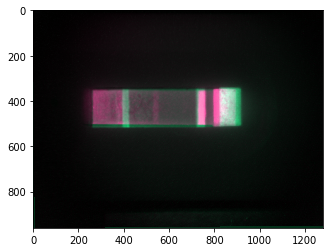

In [15]:
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed);
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(1)
resampler.SetTransform(outTx)

out = resampler.Execute(moving)

simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
sample_registered = sitk.GetArrayFromImage(simg2)
cimg = sitk.Compose(simg1, simg2, simg1//2.+simg2//2.)
# sitk.Show( cimg, "ImageRegistration2 Composition" )
plt.imshow(sitk.GetArrayFromImage(cimg))

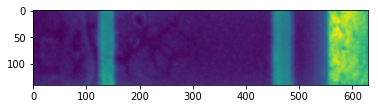

In [16]:
# cropping mask based on the template image
x1 = 270; x2 = 900; y1 = 360; y2 = 500

sample_cropped = sample_registered[y1:y2, x1:x2]
plt.imshow(sample_cropped)